<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/Data_codechallengeUnbalanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
#for number-crunching
import numpy as np
import scipy.stats as stats
#for dataset management
import pandas as pd
#for timing computations
import time
#for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Import and process the data

In [ ]:
url="https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data=pd.read_csv(url,sep=';')
#drop few outliers
data=data[data['total sulfur dioxide']<200] #drop a few outliers
##z-score all variables except for quality
#find the columns we want to normalize
# z-score all columns except for quality
cols2zscore=data.keys()
cols2zscore=cols2zscore.drop('quality')
data[cols2zscore]=data[cols2zscore].apply(stats.zscore)



In [ ]:
def createAdataset(qualThreshold):
  #create a new column for binarized quality
  data['boolQuality']=0
  #IMPORTANT: this is the main peice of this code!
  tmp=(data['quality']>qualThreshold).astype(int)
  data['boolQuality']=tmp #I also rewrote these lines from previous version to avoid the warning message
  #convert from pandas dataframe to tensor
  dataT  = torch.tensor( data[cols2zscore].values ).float()
  labels = torch.tensor( data['boolQuality'].values ).float()
  labels = labels[:,None] # transform to matrix
  #split the data
  train_data,test_data,train_labels,test_labels=train_test_split(dataT,labels,test_size=0.1)
  #then convert them into Pytorch datasets(note: already converted to tensors)
  train_data = TensorDataset(train_data,train_labels)
  test_data  = TensorDataset(test_data,test_labels)
  # finally, translate into dataloader objects
  batchsize    = 8
  train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
  test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
  return train_loader,test_loader



In [ ]:
#test the dataset and the number of samples
#note that the data are roughly balanched with thres=5 not 4 or 6
train_loader,test_loader=createAdataset(6)
#get number of high/low quality wines
qualityRatings=train_loader.dataset.tensors[1].detach()
print('%s low-rated wines'%torch.sum(qualityRatings==0).item())
print('%s high-rated wines'%torch.sum(qualityRatings==1).item())

Re-organize the data:train/test in Dataloaders

In [ ]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) ) # fully connected
    x = F.relu( self.fc2(x) )
    return self.output(x)

Train The model

In [ ]:
# a function that trains the model

# global parameter
numepochs = 500

def trainTheModel():
  # check if the model has parameters
  if not list(winenet.parameters()):
      raise ValueError("Model does not have any parameters!")

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

In [ ]:
#create the data
train_data,test_loader=createAdataset(5)
#create a model and train it
winenet = ANNwine()
trainAcc,testAcc,losses = trainTheModel()
#compute accuracy per quality type
X,y= next(iter(test_loader))
yHat=winenet(X)
itemAccuracy=((yHat>0)==y).float()
perQualAcc=[100*torch.mean(itemAccuracy[y==0]),100*torch.mean(itemAccuracy[y==1])]
perQualAcc

[tensor(98.7654), tensor(16.4557)]

Now run the entire experiment!!

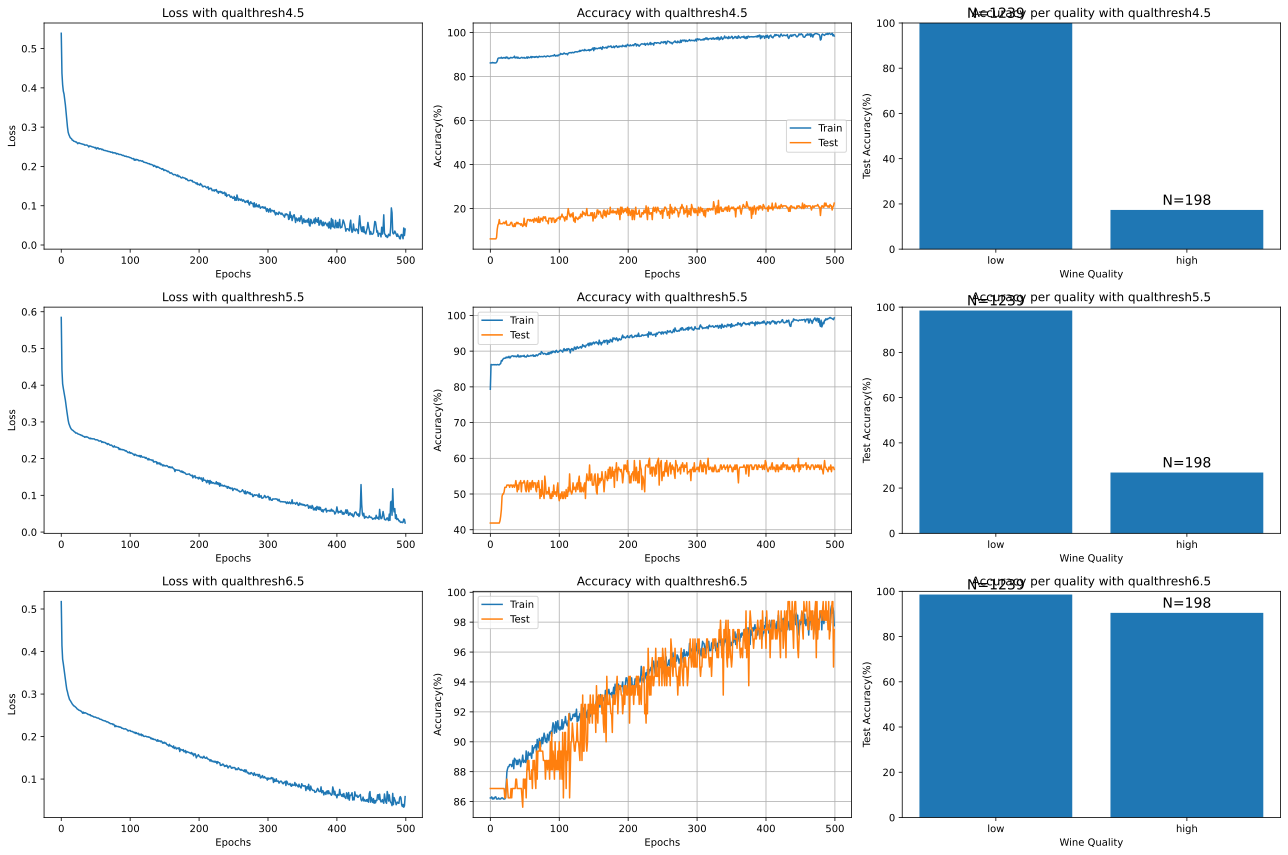

In [17]:

#setup the figure
fig,ax=plt.subplots(3,3,figsize=(18,12))
#the quality thresholda
qualityThresholds=[4,5,6]
#loop over quality thresholds
for quali in range(len(qualityThresholds)):
  #create the data
  train_data,test_loader=createAdataset(qualityThresholds[quali])
  winenet=ANNwine()
  trainAcc,testAcc,losses=trainTheModel()
  #compute accuracy  per quality type
  X,y= next(iter(test_loader))
  itemAccuracy=((winenet(X)>0)==y).float()
  perQualAcc=[100*torch.mean(itemAccuracy[y==0]),100*torch.mean(itemAccuracy[y==1])]
  #plot losses
  ax[quali,0].plot(losses)
  ax[quali,0].set_title('Loss with qualthresh'+str(qualityThresholds[quali]+.5))
  ax[quali,0].set_xlabel('Epochs')
  ax[quali,0].set_ylabel('Loss')
  #plot overall accuracy
  ax[quali,1].plot(trainAcc,label='Train')
  ax[quali,1].plot(testAcc,label='Test')
  ax[quali,1].set_title('Accuracy with qualthresh'+str(qualityThresholds[quali]+.5))
  ax[quali,1].set_xlabel('Epochs')
  ax[quali,1].set_ylabel('Accuracy(%)')
  ax[quali,1].legend()
  ax[quali,1].grid()
  #plot accuracy per quality
  bh=ax[quali,2].bar(['low','high'],perQualAcc)
  ax[quali,2].set_title('Accuracy per quality with qualthresh'+str(qualityThresholds[quali]+.5))
  ax[quali,2].set_xlabel('Wine Quality')
  ax[quali,2].set_ylabel('Test Accuracy(%)')
  ax[quali,2].set_ylim([0,100])

  #print the counts on top of each bar
  for i,r in enumerate(bh):
    N=torch.sum(train_loader.dataset.tensors[1]==i).item()
    ax[quali,2].text(r.get_x()+r.get_width()/2, r.get_height()+1,
              'N=%s'%N, ha='center', va='bottom', fontsize=14)

plt.tight_layout()
plt.show()
